In [1]:
# imports
import jax
from flax import nnx
import optax
import jax.numpy as jnp
import dataclasses

from typing import List

In [2]:
jax.devices()

[CudaDevice(id=0)]

# Configuration
This model has more parameters, let's create a special class with configuration parameters

# Configuration
This model has more parameters, let's create a special class with configuration parameters

In [3]:
@dataclasses.dataclass
class Config:
    embedded_size:int = 64

    # Image-related parameters
    image_channels:int = 3
    image_width:int = 256
    image_height:int = 256

    # Architecture related parameters
    num_residual_hiddens:int = 128
    num_residual_input:int = 32
    num_residual_layers_encoder:int = 2

    num_residual_layers_decoder:int = 2

    # quantization-related parameters
    num_quantized_vectors:int = 16*1024 
    
    # Dataset-related parameters
    dataset_name:str = 'bitmind/ffhq-256_training_faces'
    batch_size:int = 32
    

In [4]:
class ResBlock(nnx.Module):
    """One block of the encoder with a residual connection"""
    def __init__(self, config:Config, rngs: nnx.Rngs):
        super().__init__()
        self.config= config
        self.conv1 = nnx.Conv(in_features=config.num_residual_input, out_features=config.num_residual_hiddens, kernel_size=(3,3), strides=1, padding='SAME', rngs=rngs)
        self.conv2 = nnx.Conv(in_features=config.num_residual_hiddens, out_features=config.num_residual_input, kernel_size=(1,1), strides=1, padding='SAME', rngs=rngs)
    def __call__(self, inputs:jax.Array):
        out = self.conv1(inputs)
        out = jax.nn.relu(out)
        out = self.conv2(out)
        out = jax.nn.relu(out)
        return out+inputs
    

In [5]:
rngs = nnx.Rngs(0)
config = Config()
res_block = ResBlock(config, rngs)

In [6]:
class Encoder(nnx.Module):
    """VQVAE encoder"""
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.res_layers = [ResBlock(config, rngs) for _ in range(self.config.num_residual_layers_encoder)]
        # Three convolutions that reduce resolution by 2 and increase internal 
        self.initial_conv1 = nnx.Conv(in_features=config.image_channels, out_features=config.num_residual_input//2, kernel_size=(4,4), strides=(2, 2), padding='SAME', rngs=rngs)
        self.initial_conv2 = nnx.Conv(in_features=config.num_residual_input//2, out_features=config.num_residual_input, kernel_size=(4,4), strides=(2, 2), padding='SAME', rngs=rngs)
        
        
    def __call__(self, input: jax.Array):
        print('Input:', input.shape)
        x = jax.nn.relu(self.initial_conv1(input))
        print('E1 ', x.shape)
        x = jax.nn.relu(self.initial_conv2(x))
        print('E2 ', x.shape)
        for i, l in enumerate(self.res_layers):
            x = l(x)
            print('R', i, x.shape)
        # Flatten output into one vector
        x = x.flatten()
        print('O', x.shape)
        return x

In [7]:
rngs = nnx.Rngs(0)
config = Config()
encoder = Encoder(config, rngs)

In [8]:
class Decoder(nnx.Module):
    """ ... """
    def __init__(self, config: Config,  rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.res_layers = [ResBlock(config, rngs) for _ in range(self.config.num_residual_layers_decoder)]
        self.conv_transpose1 = nnx.ConvTranspose(in_features=config.num_residual_input,out_features=config.num_residual_input//2, kernel_size=(4, 4), strides=2, padding="SAME", rngs=rngs)
        self.conv_transpose2 = nnx.ConvTranspose(in_features=config.num_residual_input//2, kernel_size=(4, 4),out_features=config.image_channels, strides=2, padding="SAME", rngs=rngs)
    def __call__(self, x: jax.Array):
        # Unflatten the input
        x = x.reshape((64, 64, -1))
        for l in self.res_layers:
            x = l(x)
        print('1:', x.shape)
        x = self.conv_transpose1(x)
        print('2:', x.shape)
        x = jax.nn.relu(x)
        x = self.conv_transpose2(x)
        return x

In [9]:
rngs = nnx.Rngs(0)
config = Config()
decoder = Decoder(config, rngs)

# Datasets

In [10]:
import datasets
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import display

In [11]:
dataset = datasets.load_dataset(config.dataset_name, 'base_transforms', streaming=True)


In [12]:
batched_data =  dataset['train'].batch(config.batch_size).map(lambda x: {"x": jnp.array([jnp.array(i) for i in x["image"]])}, remove_columns=dataset["train"].column_names, batched=True, batch_size=32)

In [19]:
# Calculate averages for whitenning
min_val = 255
max_val = 0
avg_sum = 0
avg_denom = 0
for step, batch in enumerate(batched_data):
    print(step)
    data = batch['x']
    #print(jnp.min(data), jnp.max(data), jnp.sum(data), data.size)
    min_val = min(min_val, jnp.min(data))
    max_val = max(max_val, jnp.max(data))
    avg_sum += jnp.sum(data)
    avg_denom += data.size
    if step > 20:
        break
    #break
    #min_val = min(min_val, 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [21]:
min_val, max_val, avg_sum/ avg_denom

(Array(0, dtype=uint8),
 Array(255, dtype=uint8),
 Array(8.619403, dtype=float32))

In [49]:
def whitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.uint8
    return (img.astype(jnp.float32)-128+31)/128

def dewhitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.float32
    return (128.*img +128-31).astype(jnp.uint8)
    
dimage = dewhitenen(whitenen(image))
#Image.frombytes('RGB', data=dimage.tobytes(), size=(256,256))

In [50]:
whtn_batched_data = batched_data.map(lambda x: {'x': whitenen(x['x'])})

In [ ]:
for i in batched_data:
    image = i['x'] #Image.frombytes('RGB', data=i['x'].tobytes(), size=(256,256))
    break
image

In [ ]:
for i in whtn_batched_data:
    wimage = i['x']
    break
wimage

In [40]:
class EncoderDecoder(nnx.Module):
    def __init__(self, config:Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        self.encoder = Encoder(config, rngs)
        self.decoder = Decoder(config, rngs)
    def __call__(self, in_image: jax.Array) -> List[jax.Array]:
        encoded = self.encoder(in_image)
        # TODO: add quantization
        decoded = self.decoder(encoded)
        return (decoded, encoded)
        

In [ ]:
class Quantizer(nnx.Module):
    def __init__(self, config: Config, rngs: nnx.Rngs):
        super().__init__()
        self.config = config
        # Embeddings for quantization
        key = rngs.params()
        self.embeddings = nnx.Param()

In [41]:
model = EncoderDecoder(config, rngs)

# Training

In [45]:
def image_loss(orig, restored):
    return jax.numpy.mean((orig-restored)**2)

In [46]:
tx = optax.adam(0.001)
optimizer = nnx.Optimizer(model, tx)

In [55]:
def loss_fn(model, data):
    restored, _ = jax.vmap(model)(data)
    loss = image_loss(data, restored)
    return loss

In [56]:
@nnx.jit
def train_step(model: EncoderDecoder, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, data):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, data)
    optimizer.update(grads)
    metrics.update(loss=loss)

In [57]:
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

In [59]:
for step, batch in enumerate(batched_data):
    data = batch['x']
    train_step(model, optimizer, metrics, data)
    if step%100 == 0:
        print([(m, v) for m,v in metrics.compute().items()])

[('loss', Array(15087.221, dtype=float32))]
[('loss', Array(1794.9474, dtype=float32))]
[('loss', Array(1019.8223, dtype=float32))]
[('loss', Array(731.798, dtype=float32))]
[('loss', Array(578.14636, dtype=float32))]
[('loss', Array(481.87878, dtype=float32))]
[('loss', Array(414.52884, dtype=float32))]
[('loss', Array(365.54446, dtype=float32))]
[('loss', Array(328.70255, dtype=float32))]
[('loss', Array(298.7151, dtype=float32))]
[('loss', Array(274.36774, dtype=float32))]
[('loss', Array(254.01196, dtype=float32))]
[('loss', Array(237.28842, dtype=float32))]
[('loss', Array(222.63458, dtype=float32))]
[('loss', Array(210.2694, dtype=float32))]
[('loss', Array(198.90549, dtype=float32))]
[('loss', Array(188.92938, dtype=float32))]
[('loss', Array(180.15147, dtype=float32))]
[('loss', Array(172.13644, dtype=float32))]
[('loss', Array(164.90395, dtype=float32))]
[('loss', Array(158.37617, dtype=float32))]
[('loss', Array(152.4215, dtype=float32))]


ValueError: All input arrays must have the same shape.

Input: (256, 256, 3)
E1  (128, 128, 16)
E2  (64, 64, 32)
R 0 (64, 64, 32)
R 1 (64, 64, 32)
O (131072,)
1: (64, 64, 32)
2: (128, 128, 16)


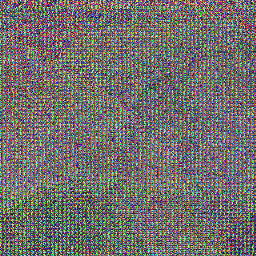

In [67]:
decoded = jax.vmap(model)(image)
Image.frombytes('RGB', data=decoded[0].tobytes(), size=(256,256))

In [68]:
image

Array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0, 117, 150],
         [  0, 118, 150],
         [  0, 114, 146]],

        [[  1, 110, 127],
         [  1, 114, 132],
         [  1, 120, 137],
         ...,
         [  0, 123, 156],
         [  0, 121, 154],
         [  0, 117, 154]],

        ...,

        [[ 33, 169, 185],
         [ 35, 169, 184],
         [ 36, 168, 186],
         ...,
         [163, 200, 206],
         [161, 200, 204],
         [159, 197, 203]],

        [[ 33, 169, 184],
         [ 36, 168, 184],
         [ 37, 167, 184],
         ...,
         [165, 202, 209],
         [165, 202, 209],
         [162, 199, 206]],

        [[ 35, 166, 183],
         [ 33, 167, 183],
         [ 34, 167, 182],
         ...,
         [161, 198, 204],
        

In [71]:
jnp.array(decoded[0], dtype=jnp.int8)

Array([[[[  5,   9,  13],
         [  5,  22,  16],
         [  2,  18,  17],
         ...,
         [ 22,  32,  36],
         [ 18,  51,  34],
         [ 32,  27,  24]],

        [[ 14,  25,  43],
         [  7,  35,  44],
         [ -9,  17,  46],
         ...,
         [  4,  50,  87],
         [ 39,  77, 123],
         [ 19,  50,  57]],

        [[ 27,  53,  52],
         [  7,  85, 100],
         [ 30,  83,  84],
         ...,
         [ 30,  92, 127],
         [ 52, 117, 127],
         [ 47,  62,  94]],

        ...,

        [[ 77, 127, 127],
         [ 53, 127, 127],
         [ 67, 127, 127],
         ...,
         [127, 127, 127],
         [127, 127, 127],
         [127, 127, 127]],

        [[ 58, 116, 122],
         [ 35, 127, 127],
         [ 67, 127, 127],
         ...,
         [127, 127, 127],
         [127, 127, 127],
         [127, 127, 127]],

        [[ 54,  64,  73],
         [ 65, 118, 127],
         [ 78, 115, 127],
         ...,
         [127, 127, 127],
        